# Vectorized Backtest

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

idx = pd.IndexSlice

#periodo target. 1 implica que queremos predecir 1 periodo siguiente. (una semana en caso de datos semanales)
periodo_target=1 

N_LONG = N_SHORT = 3
N_BEST_MODELS = 10

In [3]:
def compute_strategies(data_store, predictions_store):
    #tomamos los resultados de las 10 mejores configuraciones de los predictores
    predictions = pd.concat([pd.read_hdf(predictions_store, 'lgb/train/01'),
                            pd.read_hdf(predictions_store, 'lgb/test/01').drop('y_test', axis=1)])

    #tomamos la media
    predictions = (predictions.loc[~predictions.index.duplicated()]#si se duplican indices tomara los del train, ose los primeros
                    .iloc[:, :N_BEST_MODELS]
                    .mean(1)
                    .sort_index()
                    .dropna()
                    .to_frame('prediction'))
    

    predicciones=(predictions
                .unstack('ticker')
                .prediction)
    with pd.HDFStore(data_store) as store:
        print(store.keys())
        data = (store['data_raw']
                .sort_index()
                .loc[idx[:, :'2024'], :])
        
    #localizamos target_1m para las fechas y tickers de predictions
    fwd_returns = (data.loc[idx[predictions.index.get_level_values('ticker').unique(),
                predictions.index.get_level_values('date').unique()],:]
                .sort_index(ascending=False))

    #creamos la variable target_{lookahead} mesesm
    fwd_returns[f'target_{periodo_target}m'] = data.groupby(level='ticker')[f'return_{periodo_target}w'].shift(-periodo_target)
    fwd_returns = fwd_returns[f'target_{periodo_target}m'].unstack('ticker').sort_index()
    media = fwd_returns.mean(axis=1).shift(1)
    media.name = 'S&P 500 Equal Weight'

    # Generate Signals
    long_signals = ((predicciones
                    .where(predicciones > 0)
                    .rank(axis=1, ascending=False, method='first') <= N_LONG)
                    .astype(int))
    short_signals = ((predicciones
                    .where(predicciones < 0)
                    .rank(axis=1, method='first') <= N_SHORT)
                    .astype(int))

    # Multiply long signals by predictions and normalize each row to sum to 1
    weights_long = (long_signals.mul(predicciones)
    .div(long_signals.mul(predicciones).sum(axis=1), axis=0)
    .fillna(0))

    weights_short = (short_signals.mul(predicciones)
    .div(short_signals.mul(predicciones).sum(axis=1), axis=0)
    .fillna(0))

    # Compute Portfolio Returns
    long_returns = long_signals.mul(fwd_returns).replace(0, np.nan).mean(axis=1).fillna(0)
    short_returns = short_signals.mul(-fwd_returns).replace(0, np.nan).mean(axis=1).fillna(0)
    long_weighted_returns = weights_long.mul(fwd_returns).replace(0, np.nan).sum(axis=1).fillna(0)
    short_weighted_returns = weights_short.mul(-fwd_returns).replace(0, np.nan).sum(axis=1).fillna(0)

    # Compute Strategy Returns
    strategy = long_returns.add(short_returns).to_frame('Strategy Long Short')
    strategy_weighted = long_weighted_returns.add(short_weighted_returns).to_frame('Strategy Weighted Long Short')

    strategy_short = short_returns.to_frame('Strategy Short')
    strategy_short_weighted = short_weighted_returns.to_frame('Strategy Weighted Short')

    strategy_long = long_returns.to_frame('Strategy Long')
    strategy_long_weighted = long_weighted_returns.to_frame('Strategy Weighted Long')

    return {
        'strategies': {
            'equal_weight': strategy,
            'weighted': strategy_weighted,
            'benchmark': media,
            'long': strategy_long,
            'long_weighted': strategy_long_weighted,
            'short': strategy_short,
            'short_weighted': strategy_short_weighted
        },
        'signals': {
            'long': long_signals,
            'short': short_signals
        },
        'weights': {
            'long': weights_long,
            'short': weights_short
        },
        'returns': {
            'long': long_returns,
            'short': short_returns,
            'long_weighted': long_weighted_returns,
            'short_weighted': short_weighted_returns
        },
        'forward_returns': fwd_returns
    }

neutralized_results = compute_strategies("data_neutralized/assets.h5", "data_neutralized/predictions_neutralized_todo.h5")
neutralized_trimmed_results = compute_strategies("data_neutralized/assets.h5", "data_neutralized/predictions_neutralized_trimmed.h5")
neutralized_pca_results = compute_strategies("data_neutralized/assets.h5", "data_neutralized/predictions_neutralized_pca.h5")

normalized_results = compute_strategies("data_normalized/assets.h5", "data_normalized/predictions_normalized_todo.h5")
normalized_trimmed_results = compute_strategies("data_normalized/assets.h5", "data_normalized/predictions_normalized_trimmed.h5")
normalized_pca_results = compute_strategies("data_normalized/assets.h5", "data_normalized/predictions_normalized_pca.h5")


['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_trimmed']
['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_trimmed']
['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_trimmed']
['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_trimmed']
['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_trimmed']
['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_trimmed']


## Generate Signals

## Compute Portfolio Returns

Calculamos pesos según la predicción

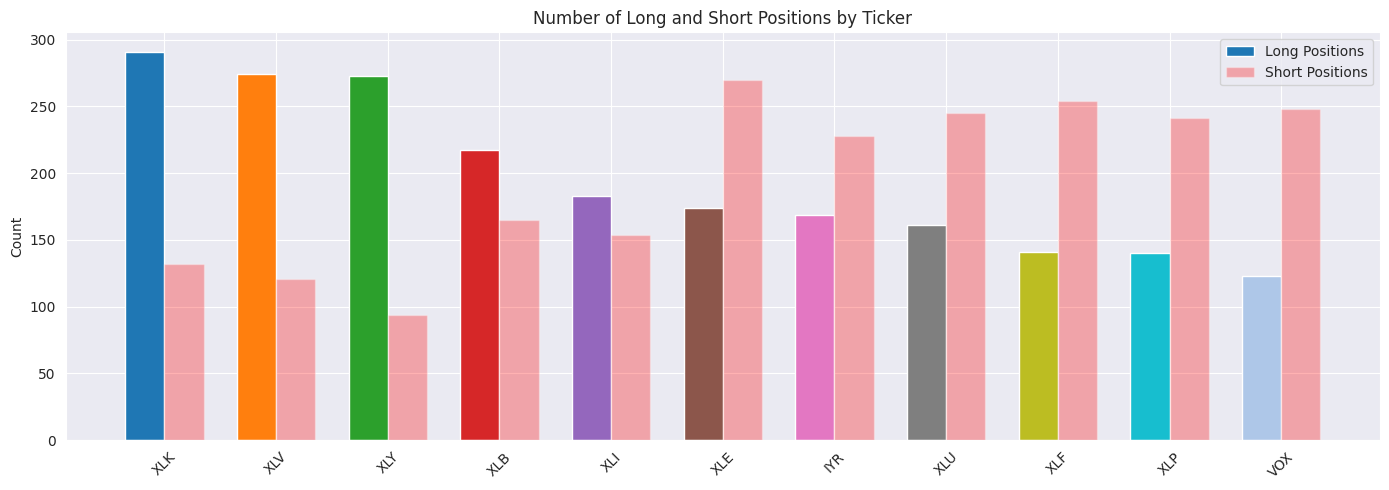

In [4]:
def plot_number_of_long_short_positions(results):
    long_signals = results['signals']['long']
    short_signals = results['signals']['short']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
    fig, ax = plt.subplots(figsize=(14,5))

    # Ordenar los datos de mayor a menor según los longs
    long_sums = long_signals.sum().sort_values(ascending=False)
    short_sums = short_signals[long_sums.index].sum()

    # Crear un índice para las posiciones de las barras
    x = np.arange(len(long_sums))
    width = 0.35  # Ancho de las barras

    # Graficar barras largas y cortas una al lado de la otra
    ax.bar(x - width/2, long_sums, width, color=colors, label='Long Positions')
    ax.bar(x + width/2, short_sums, width, color='red', alpha=0.3, label='Short Positions')

    plt.title('Number of Long and Short Positions by Ticker')
    plt.ylabel('Count')
    plt.xticks(x, long_sums.index, rotation=45)
    plt.legend()
    plt.tight_layout()

plot_number_of_long_short_positions(neutralized_trimmed_results)

## Plot results

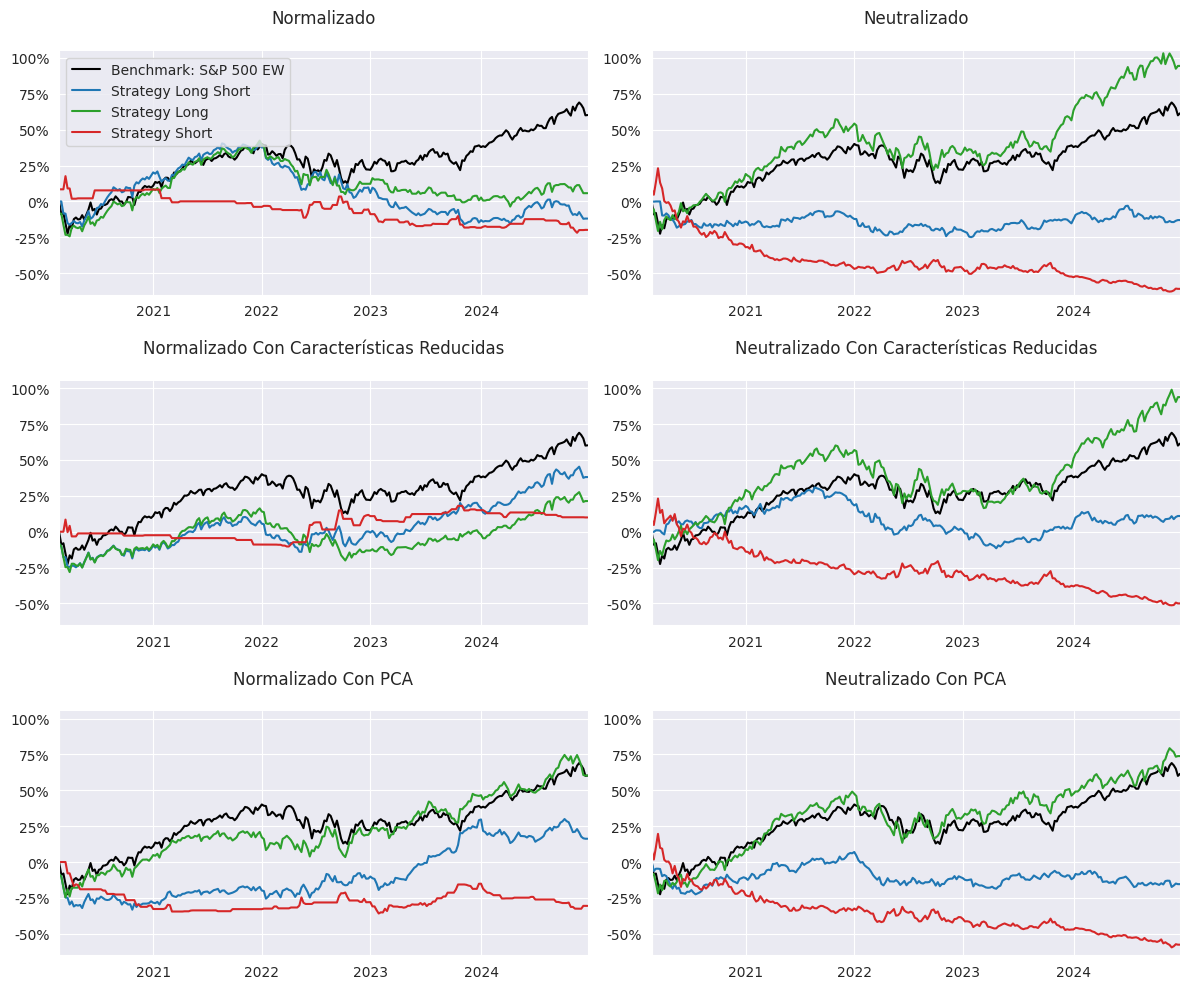

In [5]:
def plot_strategy(
    results,
    long=False,
    short=False,
    weighted=False,
    benchmark=False,
    year_start="2020",
    axes=None,
    color = None,
    legend = False
):
    strategy = results["strategies"]["equal_weight"]
    strategy_weighted = results["strategies"]["weighted"]
    strategy_long = results["strategies"]["long"]
    strategy_long_weighted = results["strategies"]["long_weighted"]
    strategy_short = results["strategies"]["short"]
    strategy_short_weighted = results["strategies"]["short_weighted"]
    media = results["strategies"]["benchmark"]
    if axes is None:
        fig, axes = plt.subplots(figsize=(10, 5))
    else:
        fig = axes.get_figure()

    if benchmark:
        axes = (
            media.loc[year_start:]
            .add(1)
            .cumprod()
            .sub(1)
            .plot(ax=axes, label="Benchmark: S&P 500 EW", color="black")
        )

    match (long, short, weighted):
        case (True, True, True):
            axes = (
                strategy_weighted.loc[year_start:]
                .add(1)
                .cumprod()
                .sub(1)
                .plot(ax=axes, label="Cumulative Return Long and Short Weighted", color=color)
            )
        case (True, False, True):
            axes = (
                strategy_long_weighted.loc[year_start:]
                .add(1)
                .cumprod()
                .sub(1)
                .plot(ax=axes, label="Cumulative Return Long Weighted", color=color)
            )
        case (False, True, True):
            axes = (
                strategy_short_weighted.loc[year_start:]
                .add(1)
                .cumprod()
                .sub(1)
                .plot(ax=axes, label="Cumulative Return Short Weighted", color=color)
            )
        case (True, True, False):
            axes = (
                strategy.loc[year_start:]
                .add(1)
                .cumprod()
                .sub(1)
                .plot(ax=axes, label="Cumulative Return Long and Short", color=color)
            )
        case (True, False, False):
            axes = (
                strategy_long.loc[year_start:]
                .add(1)
                .cumprod()
                .sub(1)
                .plot(ax=axes, label="Cumulative Return Long", color=color)
            )
        case (False, True, False):
            axes = (
                strategy_short.loc[year_start:]
                .add(1)
                .cumprod()
                .sub(1)
                .plot(ax=axes, label="Cumulative Return Short", color=color)
            )
        case _:
            raise ValueError("Invalid combination of arguments")

    axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
    if legend:
        axes.legend()
    else:
        axes.get_legend().remove()
    sns.despine()
    return axes

GREEN = "#2ca02c"
BLUE = "#1f77b4"
RED = "#d62728"


fig, axes = plt.subplots(3,2, figsize=(12,10))

# Normalized todo
axes[0,0] = plot_strategy(normalized_results, long=True, short = True, benchmark=True, color= BLUE, axes=axes[0,0])
axes[0,0] = plot_strategy(normalized_results, long=True, color= GREEN, axes=axes[0,0])
axes[0,0] = plot_strategy(normalized_results, short=True, color= RED, axes=axes[0,0], legend = True)
axes[0,0].set_title("Normalizado", pad=20)
axes[0,0].set_ylim(-0.65, 1.05)
axes[0,0].set_xlabel("")

# Normalized trimmed
axes[1,0] = plot_strategy(normalized_trimmed_results, long=True, short = True, benchmark=True, color= BLUE, axes=axes[1,0])
axes[1,0] = plot_strategy(normalized_trimmed_results, long=True, color= GREEN, axes=axes[1,0])
axes[1,0] = plot_strategy(normalized_trimmed_results, short=True, color= RED, axes=axes[1,0], legend = False)
axes[1,0].set_title("Normalizado Con Características Reducidas", pad=20)
axes[1,0].set_ylim(-0.65, 1.05)
axes[1,0].set_xlabel("")

# Normalized PCA
axes[2,0] = plot_strategy(normalized_pca_results, long=True, short = True, benchmark=True, color= BLUE, axes=axes[2,0])
axes[2,0] = plot_strategy(normalized_pca_results, long=True, color= GREEN, axes=axes[2,0])
axes[2,0] = plot_strategy(normalized_pca_results, short=True, color= RED, axes=axes[2,0], legend = False)
axes[2,0].set_title("Normalizado Con PCA", pad=20)
axes[2,0].set_ylim(-0.65, 1.05)
axes[2,0].set_xlabel("")

# Neutralized todo
axes[0,1] = plot_strategy(neutralized_results, long=True, short = True, benchmark=True, color= BLUE, axes=axes[0,1])
axes[0,1] = plot_strategy(neutralized_results, long=True, color= GREEN, axes=axes[0,1])
axes[0,1] = plot_strategy(neutralized_results, short=True, color= RED, axes=axes[0,1], legend = False)
axes[0,1].set_title("Neutralizado", pad=20)
axes[0,1].set_ylim(-0.65, 1.05)
axes[0,1].set_xlabel("")

# Neutralized Trimmed 
axes[1,1] = plot_strategy(neutralized_trimmed_results, long=True, short = True, benchmark=True, color= BLUE, axes=axes[1,1])
axes[1,1] = plot_strategy(neutralized_trimmed_results, long=True, color= GREEN, axes=axes[1,1])
axes[1,1] = plot_strategy(neutralized_trimmed_results, short=True, color= RED, axes=axes[1,1], legend = False)
axes[1,1].set_title("Neutralizado Con Características Reducidas", pad=20)
axes[1,1].set_ylim(-0.65, 1.05)
axes[1,1].set_xlabel("")

# Neutralized PCA
axes[2,1] = plot_strategy(neutralized_pca_results, long=True, short = True, benchmark=True, color= BLUE, axes=axes[2,1])
axes[2,1] = plot_strategy(neutralized_pca_results, long=True, color= GREEN, axes=axes[2,1])
axes[2,1] = plot_strategy(neutralized_pca_results, short=True, color= RED, axes=axes[2,1], legend = False)
axes[2,1].set_title("Neutralizado Con PCA", pad=20)
axes[2,1].set_ylim(-0.65, 1.05)
axes[2,1].set_xlabel("")

plt.tight_layout(h_pad=1.5)
# fig.suptitle("Backtest de las estrategias", y=1.05)



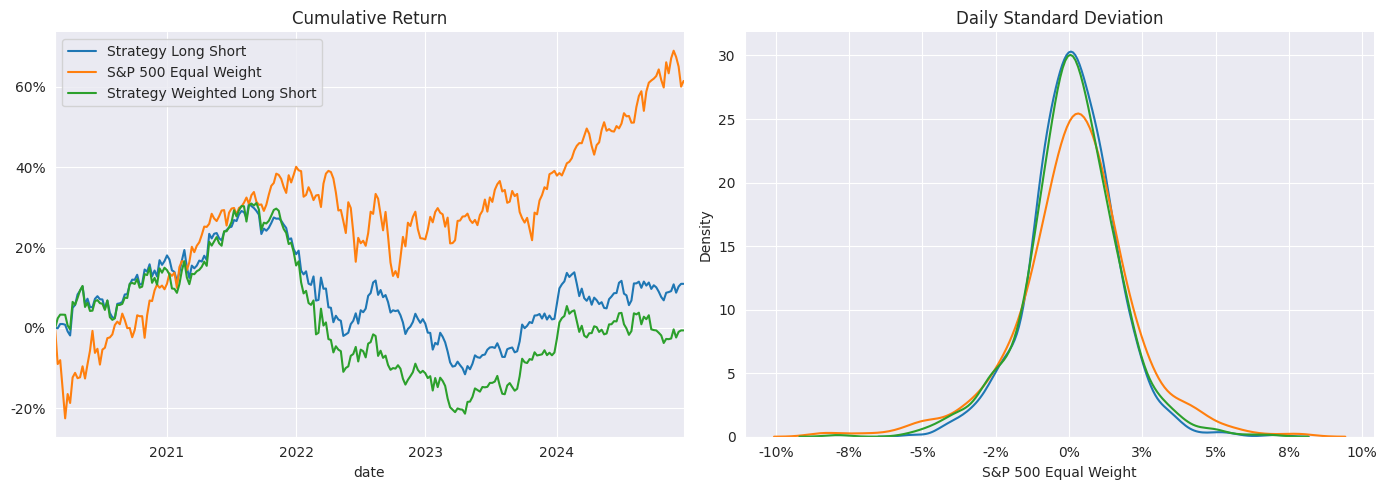

In [6]:
media = neutralized_trimmed_results['strategies']['benchmark']
strategy = neutralized_trimmed_results['strategies']['equal_weight']
strategy_weighted = neutralized_trimmed_results['strategies']['weighted']

fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
#strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout();

In [7]:
res = strategy.join(media).dropna()

In [8]:
res.std()

Strategy Long Short     0.014603
S&P 500 Equal Weight    0.020016
dtype: float64

NameError: name 'fwd_returns' is not defined

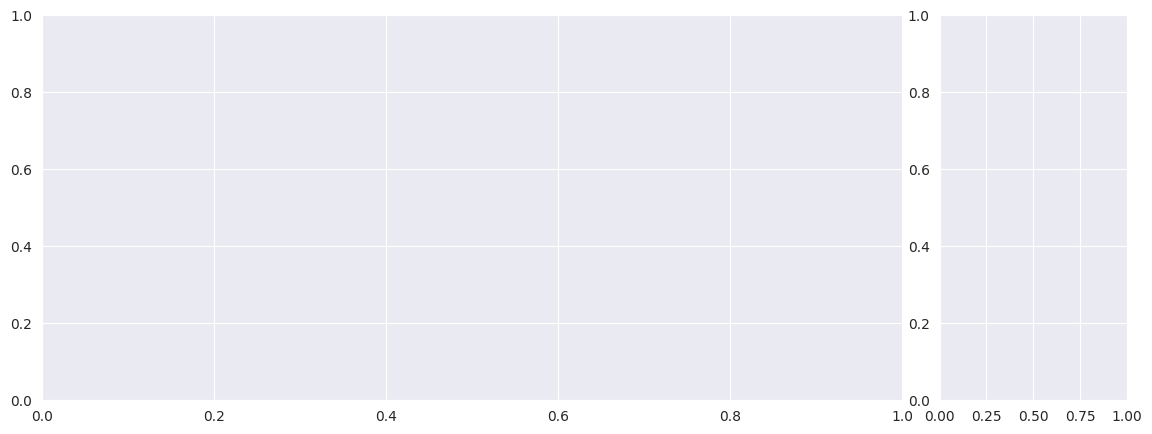

In [9]:
# fwd_returns.loc['2020':].cumsum().plot(figsize=(14,5))
# Crear figura con dos subplots
# plt.figure(figsize=(14,5))

# Subplot izquierdo - gráfico de retornos acumulados
# plt.subplot(121)
# Crear figura con GridSpec para controlar el ancho relativo de los subplots
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 5)  # 5 columnas en total
ax1 = fig.add_subplot(gs[0, :4])  # Primer subplot ocupa 4 columnas
ax2 = fig.add_subplot(gs[0, 4])   # Segundo subplot ocupa 1 columna

# Definir colores para cada ticker
colors = {'IYR': '#1f77b4', 'VOX': '#ff7f0e', 'XLB': '#2ca02c', 
          'XLE': '#d62728', 'XLF': '#9467bd', 'XLI': '#8c564b',
          'XLK': '#e377c2', 'XLP': '#7f7f7f', 'XLU': '#bcbd22', 
          'XLV': '#17becf', 'XLY': '#393b79'}

# Gráfico de retornos acumulados con colores personalizados
for ticker in fwd_returns.columns:
    data = fwd_returns.loc['2020':, ticker].cumsum()
    ax1.plot(data.index, data.values, label=ticker, color=colors[ticker])
ax1.legend()

# Gráfico de barras horizontales con los mismos colores
returns_by_ticker = fwd_returns.loc['2020':].sum().sort_values()
returns_by_ticker.plot(kind='barh', ax=ax2, 
                      color=[colors[x] for x in returns_by_ticker.index])

ax2.set_title('Retornos Totales por Ticker')
ax2.set_xlabel('Retorno Total')
plt.tight_layout()


solo largos

In [143]:
#sólo largos


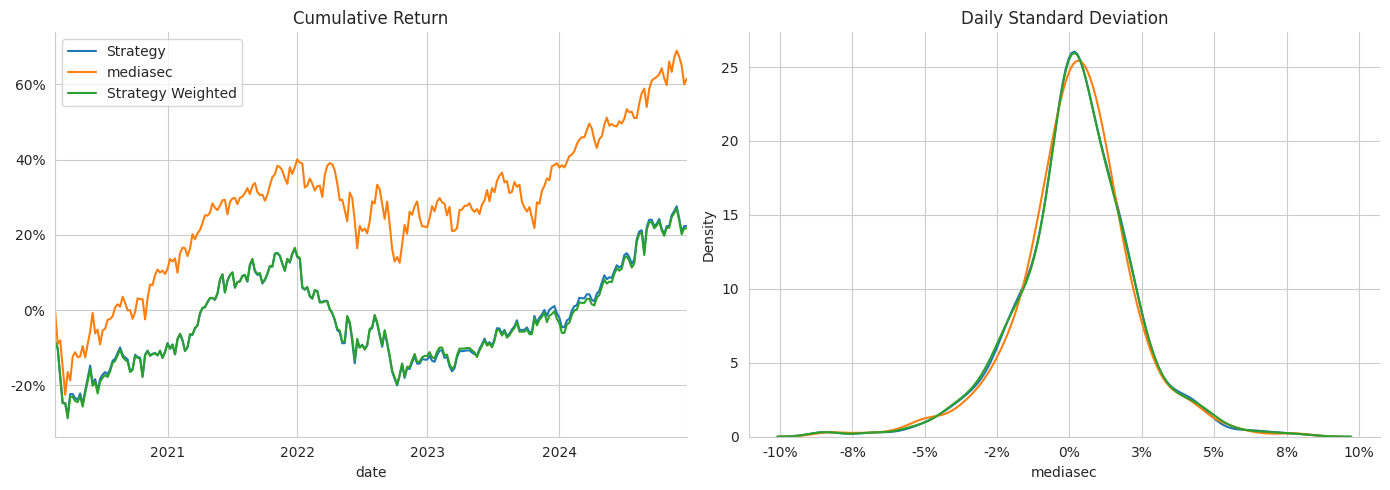

In [144]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy_long.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_long_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy_long.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_long_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout();

In [145]:
print("Fecha mínima:", strategy_long.index.min())
print("Fecha máxima:", strategy_long.index.max())

Fecha mínima: 2011-01-16 00:00:00
Fecha máxima: 2024-12-29 00:00:00


solo cortos

In [146]:
#sólo CORTOS


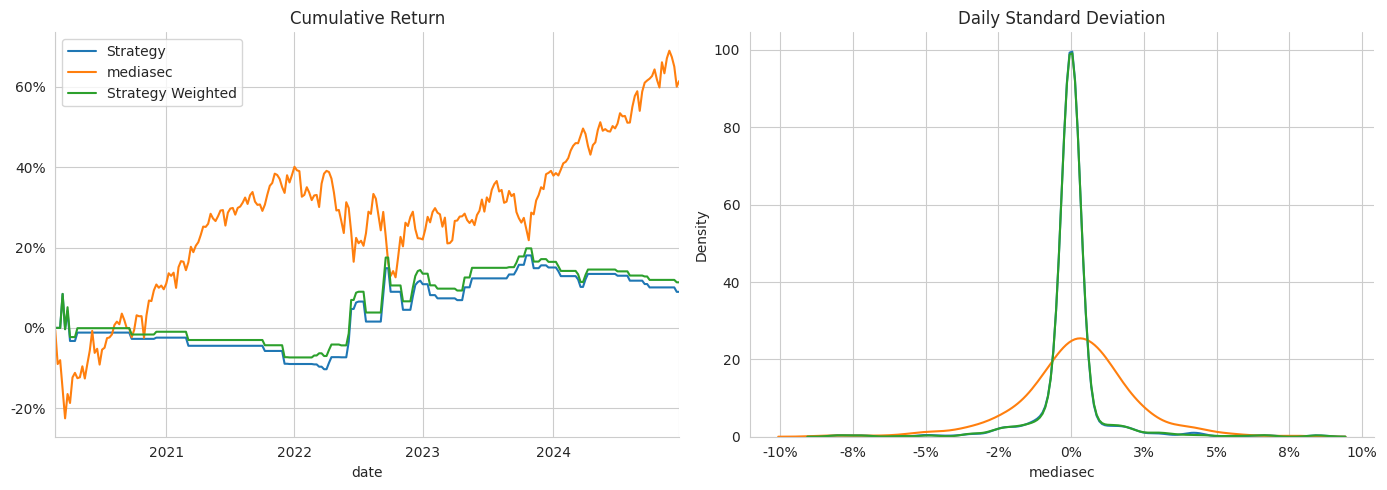

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy_short.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_short_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy_short.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_short_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();